In [78]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import random
from PIL import Image
from tqdm import tqdm_notebook as tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [99]:
class ImageTransform() :
    def __init__(self, resize, mean, std) :
        self.data_transform = {
            "train" : transforms.Compose([
                transforms.RandomResizedCrop(resize, scale = (0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)]
            ),
            "val" : transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase) :
        return self.data_transform[phase](img)

In [80]:
cat_directory = 'C:/Users/hop09/Downloads/dogs-vs-cats/cats'
dog_directory = 'C:/Users/hop09/Downloads/dogs-vs-cats/dogs'


cat_image_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_image_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
image_filepaths = [*cat_image_filepaths, *dog_image_filepaths]
correct_image_filepaths = [i for i in image_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_image_filepaths)
train_image_filepaths = correct_image_filepaths[:2400]
valid_image_filepaths = correct_image_filepaths[2400:-800]
test_image_filepaths = correct_image_filepaths[-800:]
print(len(train_image_filepaths), len(valid_image_filepaths), len(test_image_filepaths))

2400 804 800


In [55]:
print(cat_image_filepaths)

['C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.10.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.100.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1000.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1001.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1002.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1003.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1004.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1005.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1006.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1007.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1008.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1009.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.101.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1010.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1011.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\c

In [56]:
print(image_filepaths)

['C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.10.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.100.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1000.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1001.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1002.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1003.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1004.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1005.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1006.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1007.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1008.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1009.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.101.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1010.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\cat.1011.jpg', 'C:/Users/hop09/Downloads/dogs-vs-cats/cats\\c

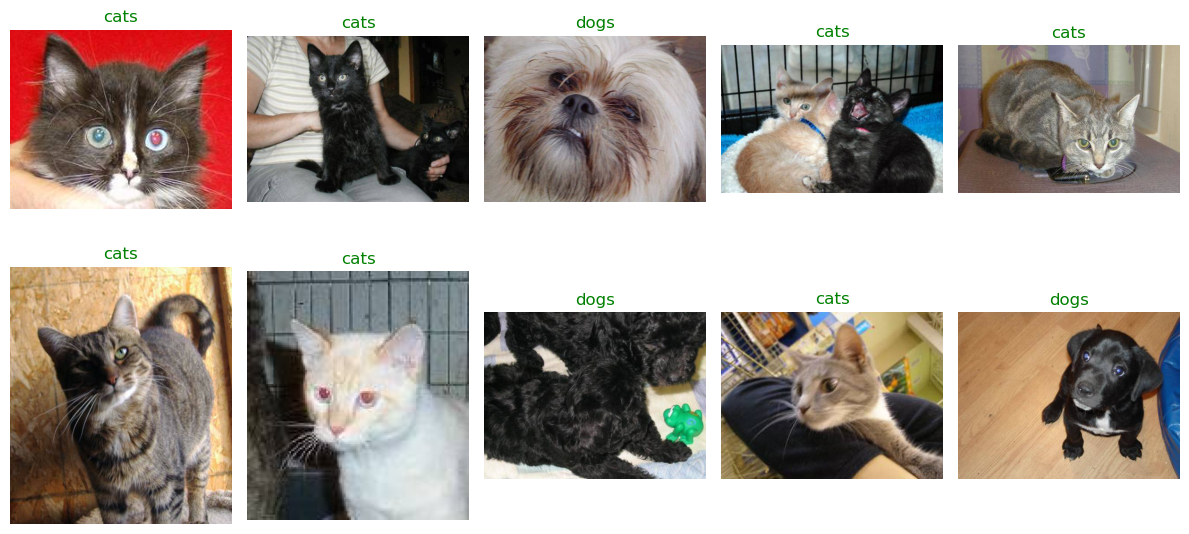

In [81]:
from matplotlib import pyplot as plt

def display_image_grid(image_filepaths, predicted_labels=(), cols=5):
    rows = len(image_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, images_filepath in enumerate(image_filepaths):
        image = cv2.imread(images_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(images_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

display_image_grid(test_image_filepaths[:10])

In [82]:
for i in range(10) :
    print(test_image_filepaths[i].split('/')[5].split('.')[-3])

cats\cat
cats\cat
dogs\dog
cats\cat
cats\cat
cats\cat
cats\cat
dogs\dog
cats\cat
dogs\dog


In [102]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list 
        self.transform = transform 
        self.phase = phase 

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx] 
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[5].split('.')[-3] 
        if label == 'dogs\dog':
            label = 1
        elif label == 'cats\cat':
            label = 0

        return img_transformed, label
        

In [84]:
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [103]:
train_dataset = DogvsCatDataset(train_image_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(valid_image_filepaths, transform=ImageTransform(size, mean, std), phase='val')
test_dataset = DogvsCatDataset(valid_image_filepaths, transform=ImageTransform(size, mean, std), phase='val')

In [104]:
index = 0
print(train_dataset.__getitem__(index)[0].size()) # 훈련 데이터의 크기
print(train_dataset.__getitem__(index)[1]) # 훈련 데이터의 레이블

torch.Size([3, 256, 256])
0


In [105]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 256, 256])
tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 1])


In [162]:
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6)) 
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [163]:
model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [164]:
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
crit = nn.CrossEntropyLoss()


In [165]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch) :
    best_acc = 0.0
    
    for epoch in range(num_epoch) :
        print("epoch {}/{}".format(epoch+1, num_epoch))
        print("-"*20)
        
        for phase in ["train", "val"] :
            if phase == "train" :
                model.train()
            else :
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0.0
            
            for inputs, labels in tqdm(dataloader_dict[phase]) :
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train") :
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == "train" :
                        loss.backward()
                        optimizer.step()
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)  
            
            print("Loss : ", epoch_loss, "Acc : ", epoch_acc)
            
    return model
        

In [166]:
num_epoch = 10
model = train_model(model, dataloader_dict, crit, optimizer, num_epoch)

epoch 1/10
--------------------


C:\Users\hop09\AppData\Local\Temp\ipykernel_2748\2621405883.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]) :


  0%|          | 0/75 [00:00<?, ?it/s]

Loss :  0.6931011382738749 Acc :  tensor(0.4988, dtype=torch.float64)


  0%|          | 0/26 [00:00<?, ?it/s]

Loss :  0.6945120028002345 Acc :  tensor(0.4900, dtype=torch.float64)
epoch 2/10
--------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Loss :  0.6929032611846924 Acc :  tensor(0.4925, dtype=torch.float64)


  0%|          | 0/26 [00:00<?, ?it/s]

Loss :  0.6920229362611153 Acc :  tensor(0.4900, dtype=torch.float64)
epoch 3/10
--------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Loss :  0.6826018198331197 Acc :  tensor(0.5504, dtype=torch.float64)


  0%|          | 0/26 [00:00<?, ?it/s]

Loss :  0.6731319860439395 Acc :  tensor(0.5796, dtype=torch.float64)
epoch 4/10
--------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Loss :  0.6836809921264648 Acc :  tensor(0.5633, dtype=torch.float64)


  0%|          | 0/26 [00:00<?, ?it/s]

Loss :  0.7012583325751385 Acc :  tensor(0.5000, dtype=torch.float64)
epoch 5/10
--------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Loss :  0.681484276453654 Acc :  tensor(0.5429, dtype=torch.float64)


  0%|          | 0/26 [00:00<?, ?it/s]

Loss :  0.650797774839164 Acc :  tensor(0.6480, dtype=torch.float64)
epoch 6/10
--------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Loss :  0.6540491151809692 Acc :  tensor(0.6229, dtype=torch.float64)


  0%|          | 0/26 [00:00<?, ?it/s]

Loss :  0.6235799472130353 Acc :  tensor(0.6692, dtype=torch.float64)
epoch 7/10
--------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Loss :  0.6435413352648417 Acc :  tensor(0.6296, dtype=torch.float64)


  0%|          | 0/26 [00:00<?, ?it/s]

Loss :  0.6821991080668435 Acc :  tensor(0.5560, dtype=torch.float64)
epoch 8/10
--------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Loss :  0.6330487410227458 Acc :  tensor(0.6175, dtype=torch.float64)


  0%|          | 0/26 [00:00<?, ?it/s]

Loss :  0.6311090514434511 Acc :  tensor(0.6468, dtype=torch.float64)
epoch 9/10
--------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Loss :  0.628812460899353 Acc :  tensor(0.6408, dtype=torch.float64)


  0%|          | 0/26 [00:00<?, ?it/s]

Loss :  0.6136110727466754 Acc :  tensor(0.6716, dtype=torch.float64)
epoch 10/10
--------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Loss :  0.6315594089031219 Acc :  tensor(0.6508, dtype=torch.float64)


  0%|          | 0/26 [00:00<?, ?it/s]

Loss :  0.6085815216178325 Acc :  tensor(0.6729, dtype=torch.float64)


In [182]:
import pandas as pd
id_list = []
pred_list = []
_id = 0
with torch.no_grad():
    for test_path in tqdm(test_image_filepaths): 
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val') 
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()

        id_list.append(_id)
        pred_list.append(preds[0])

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
}) 
res.to_csv('C:/Users/hop09/Downloads/dogs-vs-cats.csv', index=False) 

C:\Users\hop09\AppData\Local\Temp\ipykernel_2748\3289990224.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_image_filepaths):


  0%|          | 0/800 [00:00<?, ?it/s]

In [173]:
for i in range(10) :
    print(test_image_filepaths[i].split('/')[-1].split('.')[1])

1863
251
1828
1284
82
21
1880
1509
985
112


In [183]:
res.head(10)

,id,label
0,1863,0.979477
1,251,0.345750
2,1828,0.550096
3,1284,0.357852
4,82,0.425674
5,21,0.515728
6,1880,0.404452
7,1509,0.480552
8,985,0.424166
9,112,0.838301


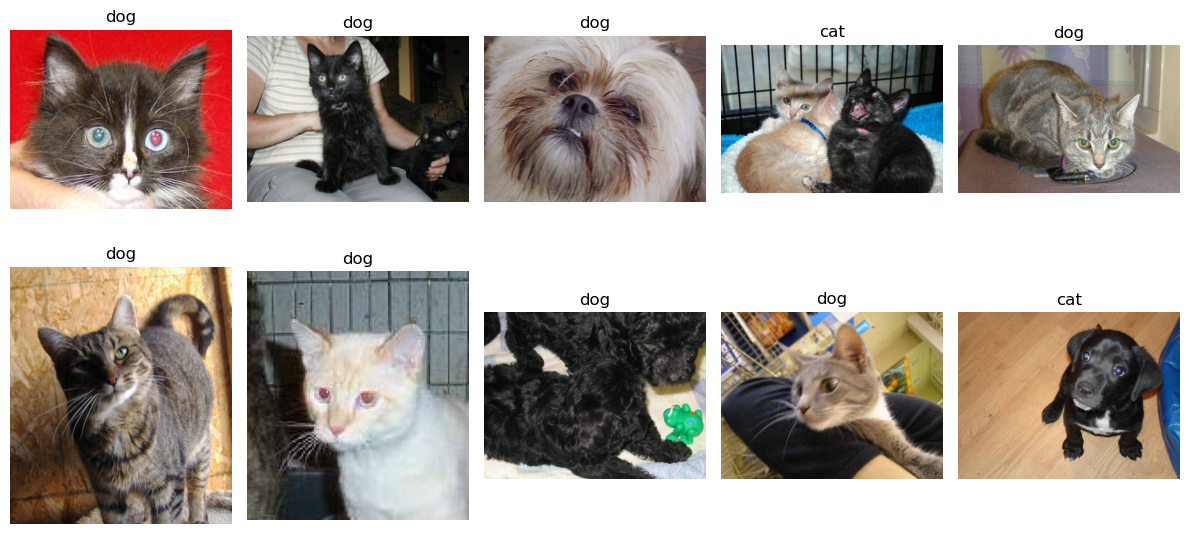

In [184]:
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

display_image_grid(test_image_filepaths[:10])